# The Fourth-Order Runge-Kutta Method for Numerical Integration 

Numerical integration is very useful for calculating results of differential equations that cannot be solved analytically. The fourth-order Runge-Kutta method (rk4) is an accurate and common technique for such integration.

### The Basic RK4 Method 

Rk4 refines techniques from [Euler](https://en.wikipedia.org/wiki/Euler_method) by taking trial steps at midpoints in order to produce a more accurate final result. These steps take the form below for a differential equation $y' = f(x,y)$ at an independent point $x_n$ and advancing to $x_{n+1}$:

$$
k_1 = hf(x_n,y_n)
$$
$$
k_2 = hf(x_n+\frac{1}{2}h,y_n + \frac{1}{2}k_1)
$$
$$
k_3 = hf(x_n+\frac{1}{2}h,y_n + \frac{1}{2}k_2)
$$
$$
k_4 = hf(x_n+h,y_n+k_3)
$$

$$
y_{n+1} \approx y_n + \frac{1}{6}k_1 + \frac{1}{3}k_2 + \frac{1}{3}k_2 + \frac{1}{6}k_4 
$$

It's useful to think of the four $k$ approximations as approximations for change in $y(x)$ from $y(x_n)$ to $y(x_{n+1})$. Then the calculation for $y_{n+1}$ takes a weighted average of all four of these, resulting in a more accurate change in $y$, and adds it to $y_n$ to get $y_{n+1}$.

### Using RK4 for higher order differential equations 

In order to use rk4 for higher order differential equations, it is necessary to think of the differential equation as a system of first order differential equations.

For example, if we once again model a mass on a spring, we know that
$$
a = x'' = -\frac{k}{m}x
$$

with values of $x_n$ and $v_n$ at the beginning of the step.

We can then write acceleration and velocity as

$$
\frac{dx}{dt} = v
$$

and
$$
\frac{dv}{dt} = x'' = -\frac{k}{m}x
$$

so what we really have is a system of first-order differential equations, which we can write as

$$
\mathbf{\dot x} = \mathbf{Ax},
$$

where

$$
\mathbf{\dot x} = \begin{pmatrix} x' \\ v' \end{pmatrix}
$$

$$
\mathbf{A} = \begin{pmatrix} 0 && 1 \\ -\frac{k}{m} && 0\end{pmatrix}
$$

and

$$
\mathbf{x} = \begin{pmatrix} x \\ v \end{pmatrix}
$$

Let's define $k_1 ... k_4$ to be the approximations for change in position and $\ell_1 ... \ell_4$ to be the approximations for change in velocity.

We must calculate $k_1$ and $\ell_1$ together, and $k_2$ and $\ell_2$ together, and so on, so that we can have midpoint approximations for both acceleration and velocity.

#### Evaluating $k_1$ and $\ell_1$

These are pretty easy because we have $x_n$ and $y_n$ for the beginning of the step. Therefore we know that

$$
k_1 = hv_n
$$
and
$$
\ell_1 = -\frac{k}{m}x_n
$$

#### Evaluating $k_2$ and $\ell_2$

Now we have to use our values for $k_1$ and $\ell_1$ to find $k_2$ and $\ell_2$.

$$
k_2 = h(v_n + \frac{1}{2}\ell_1)
$$

$$
\ell_2 = h(-\frac{k}{m}(x_n + \frac{1}{2}k_1))
$$

The same process continues for the next two change calculations.

#### Final Result

In the end, we finally get
$$
x_{n+1} \approx x_n + \frac{1}{6}k_1 + \frac{1}{3}k_2 + \frac{1}{3}k_2 + \frac{1}{6}k_4 
$$
and
$$
v_{n+1} \approx v_n + \frac{1}{6}\ell_1 + \frac{1}{3}\ell_2 + \frac{1}{3}\ell_2 + \frac{1}{6}\ell_4,
$$

similar to our result for a first order differential equation.

### Generalizing RK4 for computation 

In [1]:
import numpy as np # For more refined numerical operations
import matplotlib.pyplot as plt # For graphing
# For showing the graphs inline of the notebook.
%matplotlib inline 

It's useful to have a general rk4 in your python library so it can be called for any number of differential equations. In order to generalize rk4, we will consider the system of first order differential equations to be a vector of derivative functions and the initial conditions to be another vector. Additionally, we will code rk4 such that it can be used for vector functions (such as position, velocity, etc. in multiple dimensions) when necessary.

Our implementation of rk4 only runs one step at a time. This is so the user can implement it in a loop and collect whichever derivatives are useful to them. For example, if we were running this rk4 implementation with simple harmonic motion, we may want to take out the values for both position and velocity.

For the function below, x_init is the initial value for the independent variable, init_condns is our vector of initial conditions, params are any constant parameters needed to calculate derivatives, derivs is our vector of derivative functions, all of which take in the arguments (x_init, init_condns, params), and step_size is $h$ from above – how big we want the step size to be. step_size is an optional argument whose default setting is .01.

In [2]:
def rk4_oneStep(x_init,init_condns,params,derivs,step_size=.01):    
    
    new_init_condns = list(init_condns) # A copy of init_condns is needed due to object reference in python.
    new_x_init = x_init # new_x_init will vary with the different approximations, while x_init will not.
    

    # First approximations
    
    k_one = np.zeros_like(init_condns)
    
    # The lower-level k_ones are just calculated with the initial conditions.
    k_one[0:len(derivs)-1] = np.full_like(k_one[:len(derivs)-1],step_size) * init_condns[1:len(derivs)]
    
    # The lowest_level k_one uses its derivative function with init_condns to calculate its derivative.
    k_one[len(derivs)-1] = step_size * derivs[len(derivs)-1](x_init, init_condns, params)
    
    
    # First updates
    
    new_init_condns = init_condns + k_one/2.
    new_x_init = x_init + .5 * step_size

    
    # Second approximations
    
    k_two = np.zeros_like(init_condns)
    for i in range(len(derivs)):
        k_two[i] = step_size * derivs[i](x_init, new_init_condns, params)
    
    
    # Second updates
    
    new_init_condns = init_condns + .5 * k_two

    
    # Third approximations
    
    k_three = np.zeros_like(init_condns)
    for i in range(len(derivs)):
        k_three[i] = step_size * derivs[i](x_init,new_init_condns,params)

        
    # Third updates
    
    new_init_condns = init_condns + k_three
    new_x_init = x_init + step_size

    
    # Fourth approximations
    
    k_four = np.zeros_like(init_condns)
    for i in range(len(derivs)):
        k_four[i] = step_size * derivs[i](x_init, new_init_condns, params)

        
    # The steps are taken
    
    new_init_condns = init_condns + k_one/6. + k_two/3. + k_three/3. + k_four/6.

    
    # x_init is updated and returned so a independent data list can be compiled for plotting.
    
    x_init = x_init + step_size
      
    return [x_init,new_init_condns]


### Example: Modelling Mass on a Spring

Let's run through a computational example of this with our mass on a spring system.

#### Determining x_init 

In this case, our independent variable is time, and to simplify matters we will just start at $t=0$.

In [3]:
x_init = 0

#### Determining init_condns

We need some initial condition for position and an initial condition for velocity. Let's say that $x_0 = -1.2$ and $v_0 = 0.5$.

In [4]:
x_0 = -1.2
v_0 = 0.5

init_condns = [x_0, v_0]

#### Determining parameters

We need a value for $k$ and $m$. Let's say $k = 1$ and $m=1$.

In [5]:
k = 1.
m = 1.
parameters = [k,m]

#### Determining derivs

Let's define two functions in python as described mathematically above and make them into the list derivs.

In [6]:
def accel_spring(x_init,init_condns,params):
    k = params[0]
    m = params[1]

    x = init_condns[0]
    
    return -(k/m)*x

def vel_spring(x_init,init_condns,params):
    velocity = init_condns[1]
    return velocity

derivs = [vel_spring,accel_spring]

#### Calling the function

Let's call rk4 in a loop, extract position and time data, and see what the plot looks like.

In [7]:
# Sets the number of steps to 1000 so we can see from t=0 to t=10.
num_of_steps = 1000

# The size of the array must be 1000 + 1 to account for the initial values.
time = np.zeros(num_of_steps+1)
time[0] = x_init

position = np.zeros(num_of_steps+1)
position[0] = init_condns[0]

for i in range(1,num_of_steps+1):
    data = rk4_oneStep(x_init,init_condns,parameters,derivs)
    
    # Data stored in time and position
    position[i] = data[1][0]
    time[i] = data[0]
    
    # Conditions updated for next iteration
    x_init = data[0]
    init_condns = data[1]  

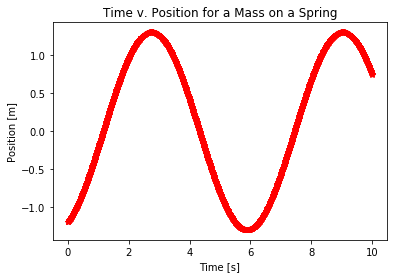

In [8]:
plt.plot(time,position,"r*")
plt.xlabel("Time [s]")
plt.ylabel("Position [m]")
plt.title("Time v. Position for a Mass on a Spring")

In case you don't believe that rk4 actually worked, let's plot this with an analytic function for simple harmonic motion and determine the residuals.

In [9]:
def SMH_pos(time,init_condns,params):
    omega = np.sqrt(params[0]/params[1])
    init_pos = init_condns[0]
    init_vel = init_condns[1]
    return init_pos*np.cos(omega*time) + init_vel/omega * np.sin(omega * time)

In [10]:
analytic_position = SMH_pos(time,[x_0,v_0],[k,m])

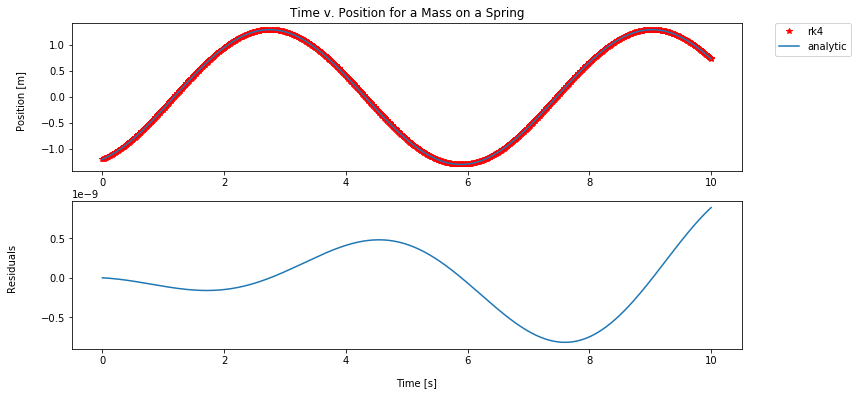

In [11]:
fig, axs = plt.subplots(2, 1, figsize=(12, 6))

axs[0].plot(time,position,"r*",label="rk4")
axs[0].plot(time,analytic_position,label="analytic")
axs[0].set_title("Time v. Position for a Mass on a Spring")
axs[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

residuals = position - analytic_position

axs[1].plot(time,residuals)

fig.text(0.5, 0.04, 'Time [s]')
fig.text(0.06, 0.75, 'Position [m]', rotation='vertical')
fig.text(.05,.35,'Residuals',rotation = 'vertical')

The residuals are very small, which indicates that rk4 is a very accurate integration technique.